In [188]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

In [189]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [190]:
############################## Eq # 1. ##############################
# Basic equation #

def f(x):
    return 3*x**2 - 4*x + 5

In [191]:
f(3.0)

20.0

In [192]:
## Let's draw the equation.
xs = np.arange(-5, 5, .25)

In [193]:
ys = f(xs)

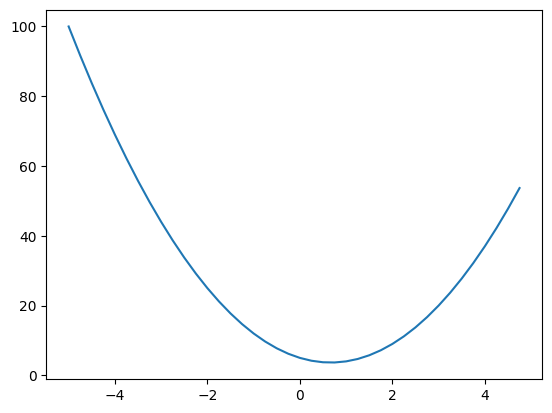

In [194]:
plt.plot(xs, ys)

In [195]:
############################## Eq # 2. ##############################
# Derivative #

In [196]:
def df(x, h=0.00000001):
    return (f(x + h) - f(x)) / h

In [197]:
df(3.0)

14.00000009255109

In [198]:
##### Since the derivative of 3x^2 - 4x + 5 is 6x - 4
##### Pluggin in will yield 6(3) - 4 = 14.

In [199]:
############################## Eq # 3. ##############################
# Complicated equations #

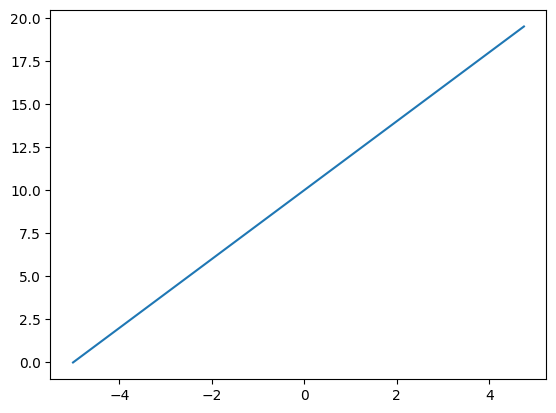

In [200]:
def cf(m, x, b):
    return m*x + b

xs = np.arange(-5, 5, .25)
ys = cf(2, xs, 10)

plt.plot(xs, ys)

In [201]:
h = 0.0001

m = 2.0
x = -3.0
b = 10.0

d1 = cf(m, x, b)

# Let's calc d1/dm or d2

d2 = cf(m, x + h, b)

grad = (d2 - d1) / h

d1, d2, grad

(4.0, 4.0002, 2.0000000000042206)

In [202]:
############################## Building Value Object. ##############################

In [213]:
class Value:
    def __init__(self, data, children=(), op='', label=''):
        self.data = data
        self._prev = set(children)
        self._op = op
        self.label = label
        
        # Ignore these for now.
        self._backward = lambda: None
        self.grad = 0
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __sub__(self, other):
        other = other.data if isinstance(other, Value) else other
        
        return self + (-other)
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def backward(self):
        # Build a topological sort
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1
        
        for node in reversed(topo):
            node._backward()

In [214]:
h = 0.0001

m = Value(2.0); m.label = 'm'
x = Value(-3.0); x.label = 'x'
b = Value(10.0); b.label = 'b'

e = m*x; e.label = 'e' # The equation is m*x + b so we need * and add operations to be introduced in the value object above.

d = e + b; d.label = 'd'

f = Value(-2.0, label='f')

L = d * f; L.label = 'L'

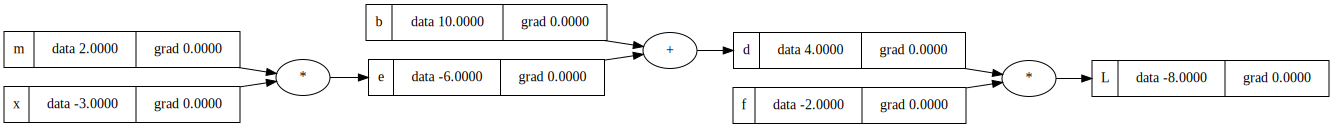

In [215]:
draw_dot(L)

In [206]:
############################## Backward Passes. ##############################

# First pass dL/df

h = 0.00000001

# Set L.grad to 1 because grad of L w.r.t to itself is 1.
## Proof.

dummy = ((L + h) - L) / h

dummy

Value(data=0.999999993922529)

In [207]:
L.grad = 1

In [208]:
# Let's calculate the value for df/dL which translates to change in L (the output) w.r.t to f.

def derivative_calculator():
    h = 0.0001

    m = Value(2.0); m.label = 'm'
    x = Value(-3.0); x.label = 'x'
    b = Value(10.0); b.label = 'b'

    e = m*x; e.label = 'e'
    d = e + b; d.label = 'd'

    f = Value(2.0, label='f')

    L = d * f; L.label = 'L'

    L1 = L.data

    m = Value(2.0); m.label = 'm'
    x = Value(-3.0); x.label = 'x'
    b = Value(10.0); b.label = 'b'

    e = m*x; e.label = 'e'
    d = e + b; d.label = 'd'

    f = Value(2.0, label='f')

    L = d * f; L.label = 'L'

    L2 = L.data
    
    print(L2, L1)
    
    print ((L2 - L1) / h)
    
derivative_calculator()

8.0 8.0
0.0


In [209]:
# Let's note the values down.
# df/dL = 4.000000000008441
# dd/dL = 1.9999999999953388

L._backward()

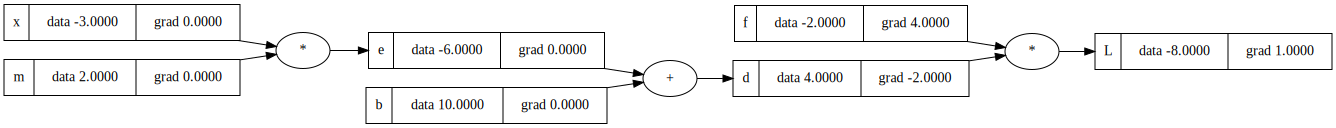

In [210]:
draw_dot(L)

In [211]:
# How do we even calculate the differential of something > 1?

# Chain rule.

# Let's say we wanna calculate db/dL?
# Chain rule says.
# db/dL = db/dd * d.grad

# Let's do local derivative first db/dd
# fx = b + e
# fxwrtb = (b+h) + e - (b+e) / h
# fxwrtb = h / h = 1

fxwrtb = 1 * -2

# by symmetry

fxwrte = 1 * -2

fxwrtb, fxwrte

(-2, -2)

In [212]:
list(L._prev)[0]._backward()

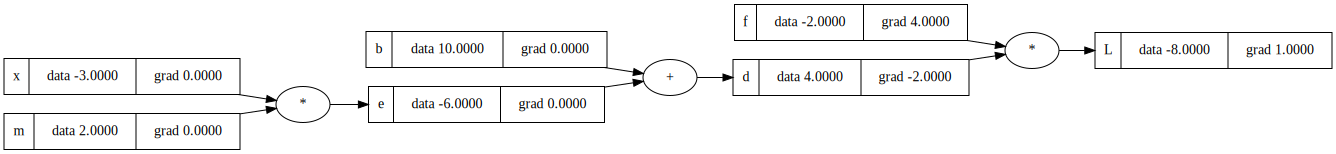

In [185]:
draw_dot(L)

In [186]:
list(list(L._prev)[0]._prev)[1]._backward()

IndexError: list index out of range

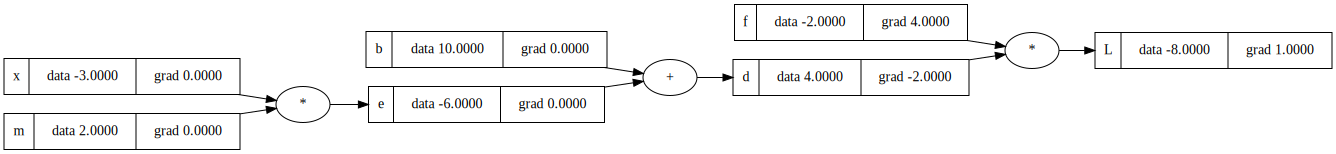

In [187]:
draw_dot(L)

In [216]:
L.backward()

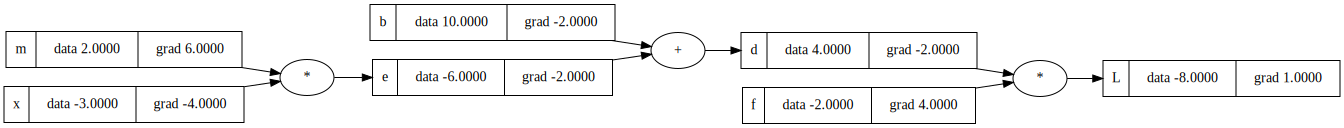

In [217]:
draw_dot(L)

In [218]:
m.data += h * m.grad
x.data += h * x.grad
b.data += h * b.grad
f.data += h * f.grad

e = m * x

d = b + e

L = d * f

L

Value(data=-7.992800640096002)

In [219]:
# Before we move forward, we have to redefine the Value object.

In [236]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._backward = lambda: None
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float."
        
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other * (self.data**(other -1))) * out.grad
            
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def tanh(self):
        x = self.data
        
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1- t**2) * out.grad
            
        out._backward = _backward
        
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def exp(self):
        x = self.data

        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def backward(self):
        # Build a topological sort
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1
        
        for node in reversed(topo):
            node._backward()

In [237]:
g = ValueComplete(4)

5 * g

Value(data=20)

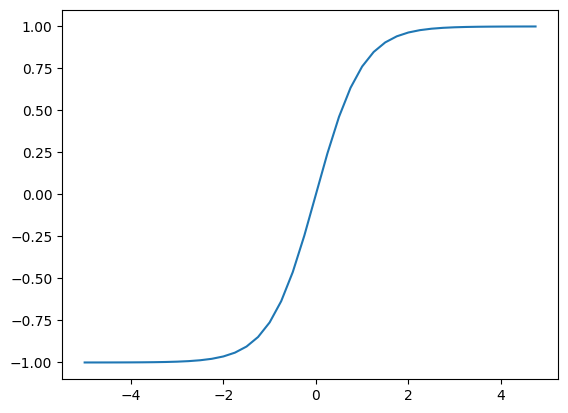

In [238]:
xs = np.arange(-5, 5, 0.25)
ys = np.tanh(xs)

plt.plot(xs, ys)

In [239]:
# Why tanh? let's say you are trying to classify images, this activation function will cap out the values at 1 so 
# you have 1, it means the resultant image is very highly likely to be your choice. It's kinda like the probability.
# We need this because the values we are getting are all over the place. This activation function will nicely cap
# it to -1 - 1.

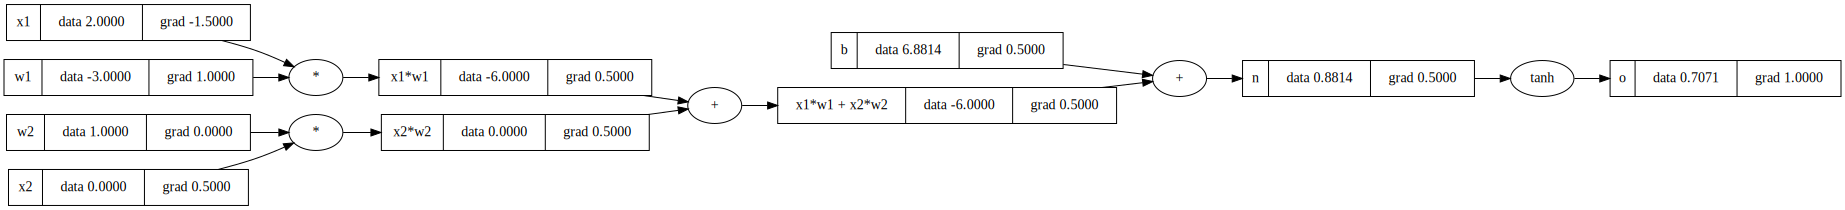

In [241]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

In [302]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        
        out = act.tanh()
        
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [303]:
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])

n.parameters()

[Value(data=0.139908587766302),
 Value(data=0.6198890022846524),
 Value(data=0.024243447646982386),
 Value(data=-0.47041644104846925),
 Value(data=-0.5106419300301606),
 Value(data=-0.842844516571521),
 Value(data=0.7546177607030378),
 Value(data=0.5162190691876971),
 Value(data=-0.5738812070277659),
 Value(data=0.45224355105788927),
 Value(data=-0.11736864383804235),
 Value(data=-0.1880363903822444),
 Value(data=0.3761288506661862),
 Value(data=-0.13391327773582606),
 Value(data=0.632896086262007),
 Value(data=-0.4489209490350181),
 Value(data=0.7747840191055764),
 Value(data=0.5987398707911544),
 Value(data=0.4450416174284455),
 Value(data=-0.7206743751569078),
 Value(data=0.680268762465781),
 Value(data=0.37262678509386715),
 Value(data=0.4378930412141968),
 Value(data=-0.6419462546323806),
 Value(data=-0.6402562666279583),
 Value(data=0.9494849765076887),
 Value(data=-0.36345243467910326),
 Value(data=0.9924163685814191),
 Value(data=0.10285628707612204),
 Value(data=0.508219180213

In [304]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [305]:
for k in range(200):
    # Forward pass 
    ypred = [n(x) for x in xs]

    # Calculate mean squared error.
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # Backward pass
    for p in n.parameters():
        p.grad = 0.0

    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 7.384509990599936
1 4.79188296349787
2 2.381979120515322
3 1.2679369221779966
4 0.6679141434972217
5 0.4180311893644732
6 0.29684349793290865
7 0.2274022254965455
8 0.18298031883788163
9 0.15235526186634202
10 0.13007707557298775
11 0.11320428535627657
12 0.10001863644824431
13 0.0894530654806498
14 0.08081183679548501
15 0.07362296979280501
16 0.06755555906038815
17 0.062371073273331884
18 0.05789343688886756
19 0.0539899804988304
20 0.0505589312029169
21 0.04752097378345621
22 0.04481342178719242
23 0.04238610609318642
24 0.04019842017948617
25 0.03821716071332733
26 0.036414925279013695
27 0.03476890702749088
28 0.033259976473493325
29 0.03187197395419592
30 0.030591158632884995
31 0.02940577521512687
32 0.028305710148197265
33 0.027282216534849656
34 0.026327692310278497
35 0.025435500067790683
36 0.024599819718077814
37 0.02381552723107913
38 0.023078094246376555
39 0.022383504493086133
40 0.021728183835739944
41 0.021108941431745076
42 0.020522920001273887
43 0.0199675536101302

In [306]:
y_pred = [n(x) for x in xs]

y_pred

[Value(data=0.9732303719213814),
 Value(data=-0.9750407287634816),
 Value(data=-0.9653336934609079),
 Value(data=0.967208846844893)]